In [1]:
import copy
import os

import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import huxt_analysis as HA
import huxt as H


In [2]:
def huxt_eqn(r, r0, v0, alpha, rh):
    """
    The HUXt equation
    Args:
        r: Radial distances
        r0: Initial radial height
        v0: Initial solar wind speed
        alpha: Solar wind acceleration constant
        rh: Solar wind acceleration scale height

    Returns:
        v: Solar wind speed as a function of radius
    """
    v = v0 * (1 + alpha*(1 - np.exp((r0 - r)/rh)))
    return v

def compute_analytical_error():
    #Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
    v_boundary = np.ones(128) * 400 * (u.km/u.s)

    # Setup HUXt to do a 1 day simulation, with model output every 4 timesteps (roughly half and hour time step), looking at 0 longitude
    model = H.HUXt(v_boundary=v_boundary, cr_num=2000, lon_out=0.0*u.deg, simtime=1*u.day, dt_scale=4)

    # Solve these conditions, with no ConeCMEs added.
    cme_list = []
    model.solve(cme_list)

    const = H.huxt_constants()
    alpha  = const['alpha']
    rh = const['r_accel']

    v0 = model.v_boundary[0]
    r = model.r
    r0 = r[0]

    v = huxt_eqn(r, r0, v0, alpha, rh)

    dv = 100*(model.v_grid[0, :, 0] - v) / v
    mae = np.mean(dv)

    return model.r, model.v_grid[0, :, 0], r, v, dv, mae


def compute_time_dependent_huxt():
    #Form longitudinal boundary conditions - background wind of 400 km/s with two fast streams.
    v_boundary = np.ones(128) * 350
    v_boundary[20:40] = 600
    v_boundary[60:80] = 600
    v_boundary[100:120] = 600
    v_boundary = v_boundary * (u.km/u.s)

    # Setup HUXt to do a 1 day simulation, with model output every 4 time steps (roughly half and hour time step), looking at 0 longitude
    model = H.HUXt(v_boundary=v_boundary, cr_num=2000, lon_out=0.0*u.deg, simtime=13*u.day, dt_scale=4)

    # Solve these conditions, with no ConeCMEs added.
    cme_list = []
    model.solve(cme_list)
    return model.r.value, model.time_out.to(u.day).value, model.v_grid[:, :, 0].value



## Figure 1.
 Plot a comparison of the numerical HUXt solution to the simple analytical example of uniform time-stationary flow at the inner boundary.

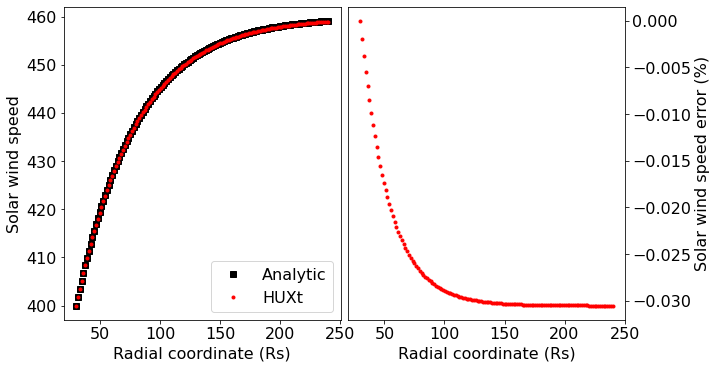

In [3]:
r_huxt, v_huxt, r, v, dv, mae = compute_analytical_error()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(r, v, 'ks', label='Analytic')

ax[0].plot(r_huxt, v_huxt, 'r.', label='HUXt')

ax[1].plot(r, dv, 'r.', label='Analytic')

ax[0].set_ylabel('Solar wind speed')
ax[1].set_ylabel('Solar wind speed error (%)')
for a in ax:
    a.set_xlabel('Radial coordinate (Rs)')

ax[0].legend()

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')

fig.subplots_adjust(left=0.09, bottom=0.12, right=0.87, top=0.99, wspace=0.025)

dirs = H._setup_dirs_()
fig_name = 'fig_analytical_error'
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".pdf")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".png")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".jpeg")
fig.savefig(fig_path, dpi=300)

## Figure 2.

Compute a convergence test for a time-dependent HUXt solution for a range of radial grid step values.

Use a synthetic solar wind background scenario, and run HUXt for 13.5 days at different radial resolutions. Compare each scenario to the finest radial resolution scenario to observe how the error evolves. Also compute the MAE and RMSE of the entire solution at each radial resoluton.

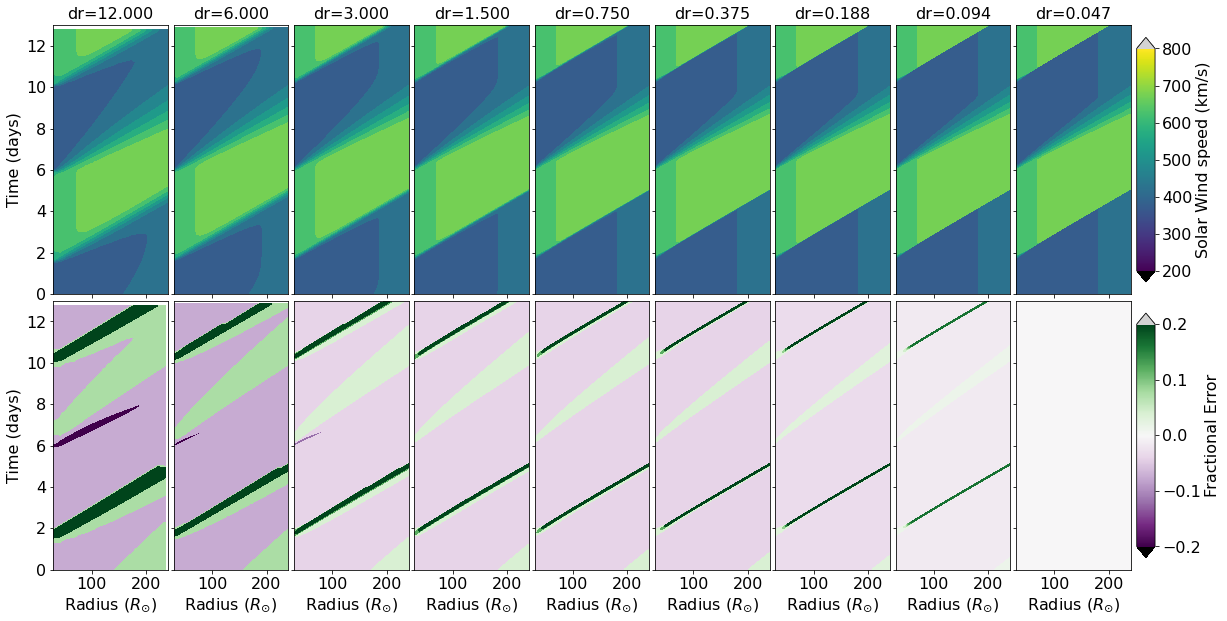

In [4]:
dr = [12/(2**i) for i in range(9)]
dr_arr = np.array(dr)
mae = np.zeros(dr_arr.shape)*np.NaN
rmse = np.zeros(dr_arr.shape)*np.NaN

# Get reference simulation with smallest dr
with open('alternative_dr.txt', 'w') as f:
        data = f.write("{:3.2f}".format(dr_arr[-1]))

r_ref, t_ref, v_ref = compute_time_dependent_huxt()
os.remove('alternative_dr.txt')

wid = 17
fig, ax = plt.subplots(2, 9, figsize=(wid, 0.5*wid))

# Loop other drs and compare with reference sim
for i, dr in enumerate(dr_arr):
    with open('alternative_dr.txt', 'w') as f:
        data = f.write("{:3.2f}".format(dr))

    r_test, t_test, v_test = compute_time_dependent_huxt()
    err = np.zeros(v_test.shape)
    v_ref_match = np.zeros(v_test.shape)
    for j, t in enumerate(t_test):
        id_t = np.argmin(np.abs(t - t_ref))
        v_r_m = np.interp(r_test, r_ref, v_ref[id_t, :], left=np.NaN, right=np.NaN)
        v_ref_match[j, :] = v_r_m

    err = v_test - v_ref_match
    frac_err = err / v_ref_match

    cnt = ax[0, i].contourf(r_test, t_test, v_test, vmin=200, vmax=800, cmap='viridis')
    # Get rid of the edge lines that show up in the pdf figures
    for c in cnt.collections:
        c.set_edgecolor("face")

    cnt = ax[1, i].contourf(r_test, t_test, frac_err, vmin=-0.2, vmax=0.2, cmap='PRGn')
    # Get rid of the edge lines that show up in the pdf figures
    for c in cnt.collections:
        c.set_edgecolor("face")


    ax[0,i].set_title('dr={:3.3f}'.format(dr), fontsize=16)

    mae[i] = np.nanmean(np.abs(frac_err))
    rmse[i] = np.sqrt(np.nanmean(frac_err**2))

    os.remove('alternative_dr.txt')

for a in ax[:,1:].ravel():
    a.set_yticklabels ([])

for a in ax[0,:].ravel():
    a.set_xticklabels ([])

for a in ax[1,:].ravel():
    a.set_xlabel ('Radius ($R_{\odot}$)')

for a in ax[:,0].ravel():
    a.set_ylabel ('Time (days)')

for a in ax.ravel():
    a.set_xlim(r_ref.min(), r_ref.max())
    a.set_ylim(t_ref.min(), t_ref.max())

fig.subplots_adjust(left=0.045, bottom=0.07, right=0.925, top=0.96, wspace=0.05, hspace=0.025)

# Speed colormap
mymap = copy.copy(mpl.cm.get_cmap("viridis"))
mymap.set_over('lightgrey')
mymap.set_under([0, 0, 0])
norm = mpl.colors.Normalize(vmin=200,vmax=800)
smp = mpl.cm.ScalarMappable(norm=norm, cmap=mymap)

pos = ax[0,-1].get_position()
dw = 0.005
dh = 0.02
left = pos.x0 + pos.width + dw
bottom = pos.y0 + dh
width = 0.015
height = pos.height - 2*dh
cbaxes = fig.add_axes([left, bottom, width, height])
cbar = fig.colorbar(smp, cax=cbaxes, orientation='vertical', extend='both')
cbar.set_label('Solar Wind speed (km/s)')

# Error colormap
mymap = copy.copy(mpl.cm.get_cmap("PRGn"))
mymap.set_over('lightgrey')
mymap.set_under([0, 0, 0])
norm = mpl.colors.Normalize(vmin=-0.20, vmax=0.2)
smp = mpl.cm.ScalarMappable(norm=norm, cmap=mymap)

pos = ax[1,-1].get_position()
dw = 0.005
dh = 0.02
left = pos.x0 + pos.width + dw
bottom = pos.y0 + dh
width = 0.015
height = pos.height - 2*dh
cbaxes = fig.add_axes([left, bottom, width, height])
cbar = fig.colorbar(smp, cax=cbaxes, orientation='vertical', extend='both')
cbar.set_label('Fractional Error')

dirs = H._setup_dirs_()
fig_name = 'fig_convergence_test'
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".pdf")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".png")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".jpeg")
fig.savefig(fig_path, dpi=300)

## Figure 3.

Make plot of MAE and RMSE against radial resolution.

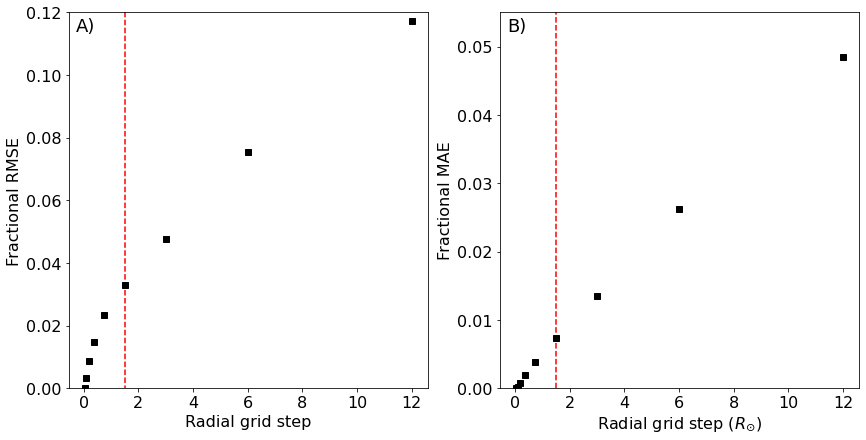

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(dr_arr, rmse, 'ks', zorder=2)
ax[0].vlines(1.5, -0.1, 0.13, linestyles=['--'], colors=['r'], zorder=1)
ax[0].set_xlabel('Radial grid step')
ax[0].set_ylabel('Fractional RMSE')

ax[1].plot(dr_arr, mae, 'ks', zorder=2)
ax[1].vlines(1.5, -0.1, 0.06, linestyles=['--'], colors=['r'], zorder=1)
ax[1].set_xlabel('Radial grid step ($R_{\odot}$)')
ax[1].set_ylabel('Fractional MAE')

ax[0].set_ylim(0, 0.12)
ax[1].set_ylim(0, 0.055)

for a, lab in zip(ax, ['A)', 'B)']):
    a.text(0.02, 0.95, lab, fontsize=18, transform=a.transAxes)
fig.subplots_adjust(left=0.075, bottom=0.1, right=0.99, top=0.97, wspace=0.2)

dirs = H._setup_dirs_()
fig_name = 'fig_dr_vs_error'
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".pdf")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".png")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".jpeg")
fig.savefig(fig_path, dpi=300)

In [6]:
print(100*mae)
print(100*rmse)

[4.85391435 2.61513112 1.3526009  0.72833865 0.38653379 0.18728328
 0.08285317 0.02367423 0.        ]
[11.71317647  7.52913002  4.77813556  3.30969046  2.34237293  1.480291
  0.86266853  0.31288738  0.        ]
